## Suport Vector Machine - Regressão

In [54]:
import numpy as np
import pandas as pd
import sklearn.feature_selection as fs
from sklearn.svm import SVR
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression
from sklearn.feature_selection import mutual_info_regression
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV

In [55]:
def daterange(start_date, end_date):
    for i in range(int((end_date - start_date).days)):
         yield start_date + datetime.timedelta(i)

In [56]:
#trocar para o cod_ibge de acordo com a cidade desejada
cidade = '3549904'

### Modelo para Casos

In [57]:
dataframe = pd.read_csv('../normalizados/dados/'+cidade+'.csv')
nome = dataframe['Município'][0]
dataframe


,Unnamed: 0,Município,Código IBGE,Populacao,Total 1ª Dose,Total 2ª Dose,Total Unica,Total Doses Aplicadas,População Vacinada dose1/População Total,População Vacinada/População Total,data,diagnostico_covid19,obito,media_movel_casos,media_movel_obitos,ocupacao_leitos,media_isolamento,Mean.R
0,0,SÃO JOSÉ DOS CAMPOS,3549904.0,729737.0,0.000000,0.002049,0.0,0.000000,0.000000,0.001787,2021-02-21,0.162562,0.235294,0.155941,0.189873,0.167532,0.539216,0.0
1,1,SÃO JOSÉ DOS CAMPOS,3549904.0,729737.0,0.017281,0.000835,0.0,0.012848,0.017281,0.000729,2021-02-22,0.315271,0.235294,0.172277,0.215190,0.164937,0.294118,0.0
2,2,SÃO JOSÉ DOS CAMPOS,3549904.0,729737.0,0.036145,0.000835,0.0,0.027152,0.036145,0.000729,2021-02-23,0.248768,0.235294,0.178218,0.240506,0.179642,0.269608,0.0
3,3,SÃO JOSÉ DOS CAMPOS,3549904.0,729737.0,0.053667,0.001054,0.0,0.040485,0.053667,0.000919,2021-02-24,0.201970,0.294118,0.180693,0.291139,0.161188,0.411765,0.0
4,4,SÃO JOSÉ DOS CAMPOS,3549904.0,729737.0,0.062456,0.001064,0.0,0.047152,0.062456,0.000928,2021-02-25,0.229064,0.176471,0.172277,0.291139,0.152249,0.264706,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
144,144,SÃO JOSÉ DOS CAMPOS,3549904.0,729737.0,0.978517,0.976042,1.0,0.978649,0.978517,0.979104,2021-07-15,0.165025,0.058824,0.105941,0.037975,0.228950,0.294118,0.0
145,145,SÃO JOSÉ DOS CAMPOS,3549904.0,729737.0,0.999898,0.999970,1.0,0.999916,0.999898,0.999974,2021-07-16,0.078818,0.000000,0.076238,0.037975,0.072953,0.245098,0.0
146,146,SÃO JOSÉ DOS CAMPOS,3549904.0,729737.0,1.000000,1.000000,1.0,1.000000,1.000000,1.000000,2021-07-17,0.140394,0.000000,0.055941,0.025316,0.074971,0.382353,0.0
147,147,SÃO JOSÉ DOS CAMPOS,3549904.0,729737.0,1.000000,1.000000,1.0,1.000000,1.000000,1.000000,2021-07-18,0.000000,0.058824,0.019307,0.000000,0.022780,0.705882,0.0


### *Seleção de atributos*

In [58]:
#usado para determinar o tamanho do conjunto de validação
tam = 30

dataframe = dataframe.set_index(['data'])
dataframe.index = pd.to_datetime(dataframe.index)
dataframe = dataframe.drop(columns=['Município', 'Código IBGE', 'Populacao', 'Unnamed: 0'])
val = dataframe[dataframe.shape[0]-tam-1:]

dataframe = dataframe[:-tam]

test_ratio = 0.2
X = dataframe.drop(columns=['diagnostico_covid19'])
y = pd.DataFrame(data=[])
y['diagnostico_covid19'] = dataframe['diagnostico_covid19']

val_ratio = test_ratio / (1 - test_ratio)

In [59]:
parametros = {'kernel': ['rbf', 'linear', 'sigmoid','poly'],
    'tol': [0.1, 0.0001, 0.00001],
    'gamma': ['scale', 'auto']
}
svr = SVR()
clf = GridSearchCV(svr, parametros, n_jobs=-1, cv=3)
Xgs = np.array(X)
ygs = np.array(y).ravel()
clf.fit(Xgs, ygs)
clf_r = clf.best_params_
clf_r

{'gamma': 'scale', 'kernel': 'linear', 'tol': 1e-05}

In [60]:
sel = fs.VarianceThreshold()
y = dataframe['diagnostico_covid19']

test_ratio = 0.5

menor = 99

for i in range(11, 0, -1):
    sel = fs.SelectKBest(fs.mutual_info_regression, k=i)
    X_sel = sel.fit_transform(X, y)
    X_train, X_test, y_train, y_test = train_test_split(X_sel, y, test_size=test_ratio, shuffle=False)
    svr = SVR(gamma= clf_r['gamma'], kernel= clf_r['kernel'], tol= clf_r['tol'])
    svr.fit(X_train, y_train)
    pred = svr.predict(X_test)
    score = mean_squared_error(y_test, pred)
    if score < menor:
        menor = score
        resul = X_sel
    print("Score com k = {} -> {}" .format(i, score))

print(resul)

Score com k = 11 -> 0.016685726500820824
Score com k = 10 -> 0.016685726500820824
Score com k = 9 -> 0.016932487926150184
Score com k = 8 -> 0.01417553390764133
Score com k = 7 -> 0.00878557642246945
Score com k = 6 -> 0.008685335085720194
Score com k = 5 -> 0.008985342645075601
Score com k = 4 -> 0.010087106304509213
Score com k = 3 -> 0.027179388146676805
Score com k = 2 -> 0.028824337527941994
Score com k = 1 -> 0.030064939437240465
[[0.00000000e+00 2.04871160e-03 0.00000000e+00 0.00000000e+00
  1.78689150e-03 1.55940594e-01]
 [1.72814474e-02 8.35396963e-04 1.28481142e-02 1.72814474e-02
  7.28635370e-04 1.72277228e-01]
 [3.61445116e-02 8.35396963e-04 2.71518018e-02 3.61445116e-02
  7.28635370e-04 1.78217822e-01]
 [5.36669409e-02 1.05419141e-03 4.04851072e-02 5.36669409e-02
  9.19468443e-04 1.80693069e-01]
 [6.24558546e-02 1.06413661e-03 4.71517598e-02 6.24558546e-02
  9.28142674e-04 1.72277228e-01]
 [6.86410561e-02 1.06413661e-03 5.18419411e-02 6.86410561e-02
  9.28142674e-04 1.7376

In [61]:
# sendo o Total 1ª Dose,Total 2ª Dose,Total Doses Aplicadas, População Vacinada dose1/População Total, População Vacinada/População Total e media_movel_casos os melhores atributos, iniciando os testes

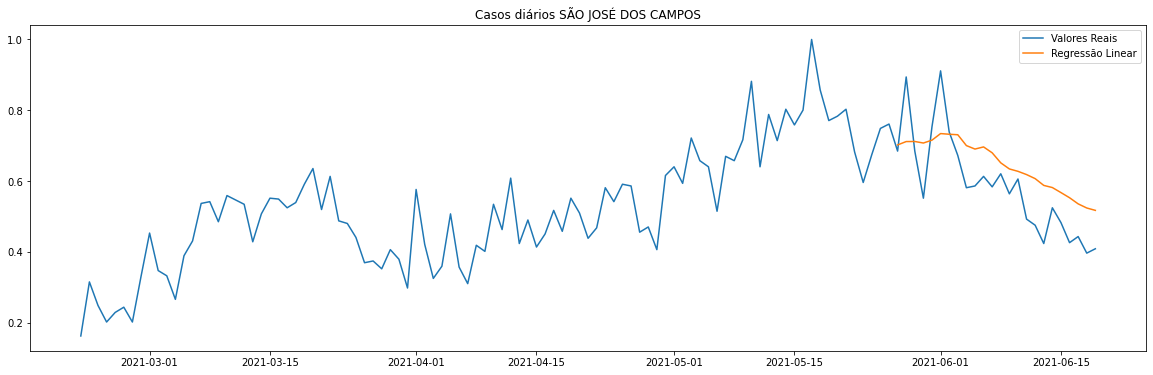

Erro quadrático
0.01106690663600142


In [62]:
df = pd.read_csv('../normalizados/dados/'+cidade+'.csv')
tam = 30
df = df.set_index(['data'])
df.index = pd.to_datetime(df.index)
df = df.drop(columns=['Município', 'Código IBGE', 'Populacao'])

val = df[df.shape[0]-tam-1:]

df = df[:-tam]

test_ratio = 0.2

X = dataframe[['media_movel_casos', 'Total 1ª Dose', 'Total 2ª Dose', 'Total Doses Aplicadas', 'População Vacinada dose1/População Total', 'População Vacinada/População Total']]
y = pd.DataFrame(data=[])
y['diagnostico_covid19'] = df['diagnostico_covid19']

val_ratio = test_ratio / (1 - test_ratio)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_ratio, shuffle=False)
ysvr = np.array(y_train).ravel()
svr = SVR(gamma= clf_r['gamma'], kernel= clf_r['kernel'], tol= clf_r['tol'])

svr.fit(X_train, ysvr)

y_pred = svr.predict(X_test)
y_pred = y_pred.tolist()


y_test.insert(1, 'pred', y_pred, True)

#print(y_test)

plt.figure(figsize=(20, 6))
plt.plot(y,label='Valores Reais')
plt.plot(y_test['pred'], label='Regressão Linear')
plt.legend()
plt.title("Casos diários " + nome)
plt.show()

print("Erro quadrático")

print(mean_squared_error(y_test['diagnostico_covid19'], y_test['pred']))

### Deslocando os últimos dias

In [63]:
def generate_time_lags(df, n_lags):
    df_n = df.copy()
    for n in range(1, n_lags + 1):
        df_n[f"lag{n}"] = df_n["media_movel_casos"].shift(n)
    df_n = df_n.iloc[n_lags:]
    return df_n

In [64]:
for dias in range(1, 15):
    menor2 = 99
    menor3= 99
    tam = 30
    test_ratio = 0.2
    
    dataframe = pd.read_csv('../normalizados/dados/'+cidade+'.csv')
    df_generated = generate_time_lags(dataframe, dias)
    
    val = df_generated[df_generated.shape[0]-tam-1:]
    df_generated = df_generated[:-tam]
    
    #print(lista)
    lista = ['media_movel_casos', 'Total 1ª Dose', 'Total 2ª Dose', 'Total Doses Aplicadas', 'População Vacinada dose1/População Total', 'População Vacinada/População Total']
    for r in range(1, dias+1):
        lista.append(f'lag{r}')
    X = df_generated[lista]
    
    y = pd.DataFrame(data=[])
    y['diagnostico_covid19'] = df_generated['diagnostico_covid19']

    val_ratio = test_ratio / (1 - test_ratio)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_ratio, shuffle=False)

    svr  = SVR(gamma= clf_r['gamma'], kernel= clf_r['kernel'], tol= clf_r['tol'])
    ysvr = np.array(y_train).ravel()
    svr.fit(X_train, ysvr)

    y_pred = svr.predict(X_test)
    y_pred = y_pred.tolist()
    
    y_test.insert(1, 'pred', y_pred, True)
    h = mean_squared_error(y_test['diagnostico_covid19'], y_test['pred'])
    if(h < menor2):
        menor2 = h
        menor3 = dias
    print(str(dias) + " -> "+ str(mean_squared_error(y_test['diagnostico_covid19'], y_test['pred'])))


1 -> 0.009862894609744342
2 -> 0.010452097212941608
3 -> 0.010918764324711403
4 -> 0.012064602642620553
5 -> 0.011868482553158621
6 -> 0.011404014500528366
7 -> 0.011474553531132968
8 -> 0.014884819762012893
9 -> 0.016290862620472364
10 -> 0.016803642800184558
11 -> 0.018332891887929397
12 -> 0.022205620987364852
13 -> 0.021695199784883726
14 -> 0.024358340743972202


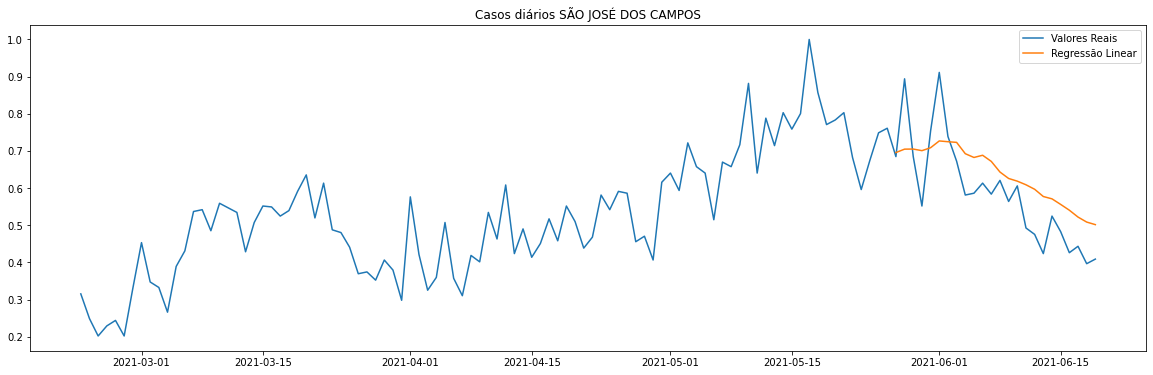

Erro quadrático
0.009862894609745177


In [74]:
df = pd.read_csv('../normalizados/dados/'+cidade+'.csv')
tam = 30
df = df.set_index(['data'])
df.index = pd.to_datetime(df.index)
df = df.drop(columns=['Município', 'Código IBGE', 'Populacao'])
df = generate_time_lags(df, 1)

val = df[df.shape[0]-tam-1:]

df = df[:-tam]

test_ratio = 0.2

X = df[['lag1','media_movel_casos', 'Total 1ª Dose', 'Total 2ª Dose', 'Total Doses Aplicadas', 'População Vacinada dose1/População Total', 'População Vacinada/População Total']]
y = pd.DataFrame(data=[])
y['diagnostico_covid19'] = df['diagnostico_covid19']

val_ratio = test_ratio / (1 - test_ratio)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_ratio, shuffle=False)
ysvr = np.array(y_train).ravel()
svr = SVR(gamma= clf_r['gamma'], kernel= clf_r['kernel'], tol= clf_r['tol'])

svr.fit(X_train, ysvr)

y_pred = svr.predict(X_test)
y_pred = y_pred.tolist()


y_test.insert(1, 'pred', y_pred, True)

#print(y_test)

plt.figure(figsize=(20, 6))
plt.plot(y,label='Valores Reais')
plt.plot(y_test['pred'], label='Regressão Linear')
plt.legend()
plt.title("Casos diários " + nome)
plt.show()

print("Erro quadrático")

print(mean_squared_error(y_test['diagnostico_covid19'], y_test['pred']))

## *Realizando modelo para óbitos*

In [ ]:
dataframe = pd.read_csv('../normalizados/dados/'+cidade+'.csv')
dataframe.head(5)

### Seleção de atributos

In [ ]:
tam = 30
dataframe = dataframe.set_index(['data'])
dataframe.index = pd.to_datetime(dataframe.index)
dataframe = dataframe.drop(columns=['Município', 'Código IBGE', 'Populacao', 'Unnamed: 0'])
val = dataframe[dataframe.shape[0]-tam-1:]

dataframe = dataframe[:-tam]

test_ratio = 0.2
X = dataframe.drop(columns=['obito'])
y = pd.DataFrame(data=[])
y['obito'] = dataframe['obito']

val_ratio = test_ratio / (1 - test_ratio)

sel = fs.VarianceThreshold()
y = dataframe['obito']

test_ratio = 0.5

menor = 99

for i in range(11, 0, -1):
    sel = fs.SelectKBest(fs.mutual_info_regression, k=i)
    X_sel = sel.fit_transform(X, y)
    X_train, X_test, y_train, y_test = train_test_split(X_sel, y, test_size=test_ratio, shuffle=False)
    linear = LinearRegression()
    linear.fit(X_train, y_train)
    pred = linear.predict(X_test)
    score = mean_squared_error(y_test, pred)
    if score < menor:
        menor = score
        resul = X_sel
    print("Score com k = {} -> {}" .format(i, score))
    
print(resul)

In [ ]:
df = pd.read_csv('../normalizados/dados/'+cidade+'.csv')
tam = 30
df = df.set_index(['data'])
df.index = pd.to_datetime(df.index)
df = df.drop(columns=['Município', 'Código IBGE', 'Populacao'])

val = df[df.shape[0]-tam-1:]

df = df[:-tam]

test_ratio = 0.2

X = dataframe.drop(columns=['obito', 'media_isolamento', 'Mean.R'])
y = pd.DataFrame(data=[])
y['obito'] = df['obito']

val_ratio = test_ratio / (1 - test_ratio)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_ratio, shuffle=False)

linear = LinearRegression()
linear.fit(X_train, y_train)

y_pred = linear.predict(X_test)

pred2 = []

for i in y_pred:
    pred2.append(i[0])
    
y_test.insert(1, 'pred', pred2, True)

#print(y_test)

plt.figure(figsize=(20, 6))
plt.plot(y,label='Valores Reais')
plt.plot(y_test['pred'], label='Regressão Linear')
#plt.plot(dataframe['media_movel_casos'], label='Regressão Linear')
plt.legend()
plt.title("Número de óbitos " + nome)
plt.show()

print("Erro quadrático")
print(mean_squared_error(y_test['obito'], y_test['pred']))

### Utilizando a média deslocada dos últimos dias

In [ ]:
def generate_time_lags2(df, n_lags):
    df_n = df.copy()
    for n in range(1, n_lags + 1):
        df_n[f"lag{n}"] = df_n["media_movel_obitos"].shift(n)
    df_n = df_n.iloc[n_lags:]
    return df_n

In [ ]:
for dias in range(0, 15):
    
    menor = 99
    tam = 30
    test_ratio = 0.2
    
    dataframe = pd.read_csv('../normalizados/dados/'+cidade+'.csv')
    df_generated = generate_time_lags2(dataframe, dias)
    
    val = df_generated[df_generated.shape[0]-tam-1:]
    df_generated = df_generated[:-tam]
    
    lista = ['media_movel_obitos', 'media_isolamento']
    
    for k in range(1, dias+1):
        lista.append(f"lag{k}")
    #print(lista)
    X = df_generated[lista]
    
    y = pd.DataFrame(data=[])
    y['obito'] = df_generated['obito']

    val_ratio = test_ratio / (1 - test_ratio)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_ratio, shuffle=False)

    linear = LinearRegression()
    linear.fit(X_train, y_train)

    y_pred = linear.predict(X_test)

    pred2 = []

    for i in y_pred:
        pred2.append(i[0])

    y_test.insert(1, 'pred', pred2, True)
    
    h = mean_squared_error(y_test['obito'], y_test['pred'])
    if(h < menor):
        menor = h
        menor2 = dias

    print(str(dias) + " -> "+ str(mean_squared_error(y_test['obito'], y_test['pred'])))


In [ ]:
input_dim = menor2
tam = 30

dataframe = pd.read_csv('../normalizados/dados/'+cidade+'.csv')
df_generated = generate_time_lags2(dataframe, input_dim)
df_generated

val = df_generated[df_generated.shape[0]-tam-1:]
df_generated = df_generated[:-tam]
test_ratio = 0.2

lista = ['media_movel_obitos', 'media_isolamento']

for k in range(1, input_dim+1):
    lista.append(f"lag{k}")

X = df_generated[lista]
y = pd.DataFrame(data=[])
y['obito'] = df_generated['obito']

val_ratio = test_ratio / (1 - test_ratio)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_ratio, shuffle=False)

linear = LinearRegression()
linear.fit(X_train, y_train)

y_pred = linear.predict(X_test)

pred2 = []

for i in y_pred:
    pred2.append(i[0])
    
y_test.insert(1, 'pred', pred2, True)

#print(y_test)

plt.figure(figsize=(20, 6))
plt.plot(y,label='Valores Reais')
plt.plot(y_test['pred'], label='Regressão Linear')
#plt.plot(dataframe['media_movel_casos'], label='Regressão Linear')
plt.title("Curva de óbitos " + nome)
plt.legend()
plt.show()

print("Erro quadrático")
print(mean_squared_error(y_test['obito'], y_test['pred']))

## Normalização utilizando standard

In [ ]:
dataframe = pd.read_csv('../Finais/'+cidade+'.csv')
dataframe

In [ ]:
scaler = StandardScaler()
norma = scaler.fit_transform(dataframe.drop(columns = ['Unnamed: 0', 'Município', 'Código IBGE', 'data']))
df_scaled = pd.DataFrame(norma, columns=dataframe.drop(columns = ['Unnamed: 0', 'Município', 'Código IBGE', 'data']).columns)
df_scaled[[ 'Município', 'Código IBGE', 'data']] = dataframe[[ 'Município', 'Código IBGE', 'data']]
df_scaled

In [ ]:
for dias in range(0, 15):
    
    tam = 30
    test_ratio = 0.2
    

    df_generated = generate_time_lags(df_scaled, dias)
    
    val = df_generated[df_generated.shape[0]-tam-1:]
    df_generated = df_generated[:-tam]
    
    lista = ['media_movel_casos']
    for k in range(1, dias+1):
        lista.append(f"lag{k}")
    #print(lista)
    X = df_generated[lista]
    
    y = pd.DataFrame(data=[])
    y['diagnostico_covid19'] = df_generated['diagnostico_covid19']

    val_ratio = test_ratio / (1 - test_ratio)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_ratio, shuffle=False)

    linear = LinearRegression()
    linear.fit(X_train, y_train)

    y_pred = linear.predict(X_test)

    pred2 = []

    for i in y_pred:
        pred2.append(i[0])

    y_test.insert(1, 'pred', pred2, True)

    print(str(dias) + " -> "+ str(mean_squared_error(y_test['diagnostico_covid19'], y_test['pred'])))
